# XGBoost & Hyperparameter tuning


* [1. Loading and Inspecting Data](#2.-Loading-and-Inspecting-Data)
* [2. Data preprocessing](#3.-Data-preprocessing)
* [2.1 Fill NaN values](#3.1-Fill-NaN-values)
* [2.2 Encoding ordinal features](#3.2-Encoding-ordinal-features)
* [2.3 Encode nominal features](#3.3-Encode-nominal-features)
* [3. Feature Engineering](#4.-Feature-Engineering)
* [4. Normalize](#5.-Normalize)
* [5. Fit Models](#6.-Fit-Models)
* [5.1 Base line model](#6.1-Base-line-model)
* [5.2 XGBoost](#6.2-XGBoost)
    * [Parameters](#Parameters)
    * [Tuning the hyper-parameters](#Tuning-the-hyper-parameters)
    * [Best Fit](#Best-Fit)
* [6. Compare Models](#7.-Compare-Models)
* [7. Plot Results](#8.-Plot-Results)
* [8. Predic Test & Submission](#9.-Predic-Test-&-Submission)





<br>Reference:</br>
<br>https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
<br>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
<br>https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
<br>https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# 1. Loading and Inspecting Data

In [1]:
#Importing packages
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load dataset
train = pd.read_csv("../input/train.csv")
test  = pd.read_csv("../input/test.csv")

In [3]:
#Dataset shape
print('Train %s\nTest %s' % (train.shape, test.shape))

Train (1460, 81)
Test (1459, 80)


In [4]:
#Feature to predict
ft_pred = list(set(train.columns) - set(test.columns))
ft_pred

['SalePrice']

In [5]:
train[ft_pred].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


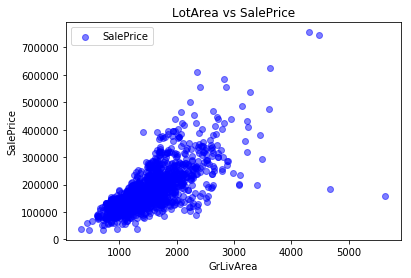

In [6]:
#Plot GrLivArea vs SalePrice
plt.scatter(train['GrLivArea'], train['SalePrice'], color='blue', alpha=0.5)
plt.title("LotArea vs SalePrice")
plt.legend(loc='best')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

# 2. Data preprocessing

<ul>
    <li>First I'll replace the numeric missing values (NaN's) with 0 and non numeric with none.
    <li>Create Dummy variables for the categorical features.
    <li>transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal.
</ul>

## 2.1 Fill NaN values

In [7]:
#save and drop id
train_id = train["Id"]
train.drop(columns='Id',inplace=True)

test_id = test["Id"]
test.drop(columns='Id',inplace=True)

#select object columns
obj_col = train.columns[train.dtypes == 'object'].values

#select non object columns
num_col = train.columns[train.dtypes != 'object'].values
num_col_test = test.columns[test.dtypes != 'object'].values

#replace null value in obj columns with None
train[obj_col] = train[obj_col].fillna('None')
test[obj_col] = test[obj_col].fillna('None')

#replace null value in numeric columns with 0
train[num_col] = train[num_col].fillna(0)
test[num_col_test] = test[num_col_test].fillna(0)

train_001 = train
test_001 = test

## 2.2 Encoding ordinal features

In [8]:
import category_encoders as ce

#Ordinal features
ordinal_features = ["ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure", "BsmtFinType1","BsmtFinType2",
                    "HeatingQC","Electrical","KitchenQual", "FireplaceQu","GarageQual","GarageCond","PoolQC"]

#Split X,y
train_002_X = train_001.drop(ft_pred, axis=1)
train_002_y = train_001[ft_pred]

ce_one_hot = ce.OrdinalEncoder(cols = ordinal_features)

train_003 = pd.concat([ce_one_hot.fit_transform(train_002_X), train_002_y], axis=1, sort=False)
test_003  = ce_one_hot.transform(test_001)


## 2.3 Encode nominal features

In [9]:
#Nominal features
nominal_features = [x for x in obj_col if x not in ordinal_features]

#Transfer object to int
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#for loop nominal feature column
for i in train_003[nominal_features].columns:
    #fit and transform each column and assign to itself
    train_003[i] = labelencoder.fit_transform(train_003[i])
    
#for loop nominal feature column
for i in test_003[nominal_features].columns:
    #fit and transform each column and assign to itself
    test_003[i] = labelencoder.fit_transform(test_003[i])
    
#Get dummy variable for nominal features
train_005 = pd.get_dummies(train_003,columns=nominal_features,drop_first=True)
test_005 = pd.get_dummies(test_003,columns=nominal_features,drop_first=True)

In [10]:
#Only for test set
#Check if any null values
print(train_005.isnull().any().sum())
print(test_005.isnull().any().sum())

#Get missing columns in the training test
missing_cols = set(train_005.drop(columns="SalePrice").columns) - set(test_005.columns)

#Add a missing column in test set with default value equal to 0
for cols in missing_cols:
    test_005[cols] = 0
    
#Ensure the order of column in the test set is in the same order than in train set
test_005 = test_005[train_005.drop(columns="SalePrice").columns]

0
0


# 3. Feature Engineering

In [11]:


#TotalBath
train_005['TotalBath'] = (train_005['FullBath'] + train_005['HalfBath'] + train_005['BsmtFullBath'] + train_005['BsmtHalfBath'])
test_005['TotalBath']  = (test_005['FullBath']  + test_005['HalfBath']  + test_005['BsmtFullBath']  + test_005['BsmtHalfBath'])

#TotalPorch
train_005['TotalPorch'] = (train_005['OpenPorchSF'] + train_005['3SsnPorch'] + train_005['EnclosedPorch'] + train_005['ScreenPorch'] + train_005['WoodDeckSF'])
test_005['TotalPorch']  = (test_005['OpenPorchSF']  + test_005['3SsnPorch']  + test_005['EnclosedPorch']  + test_005['ScreenPorch']    + test_005['WoodDeckSF'])

#Modeling happen during the sale year
train_005["RecentRemodel"] = (train_005["YearRemodAdd"] == train_005["YrSold"]) * 1
test_005["RecentRemodel"]  = (test_005["YearRemodAdd"]  == test_005["YrSold"]) * 1

#House sold in the year it was built
train_005["NewHouse"] = (train_005["YearBuilt"] == train_005["YrSold"]) * 1
test_005["NewHouse"]  = (test_005["YearBuilt"]  == test_005["YrSold"]) * 1

#HasPool
train_005['HasPool'] = train_005['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_005['HasPool']  = test_005['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#HasFireplaces
train_005['HasFirePlace'] = train_005['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
test_005['HasFirePlace']  = test_005['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#Has2ndFloor
train_005['Has2ndFloor'] = train_005['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test_005['Has2ndFloor']  = test_005['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#HasGarage
train_005['HasGarage'] = train_005['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test_005['HasGarage']  = test_005['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#HasBsmnt
train_005['HasBsmnt'] = train_005['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test_005['HasBsmnt']  = test_005['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

# 5. Fit Models

In [12]:
#Importing packages
from sklearn.model_selection import train_test_split

X = train_005.drop(columns="SalePrice")
y = train_005["SalePrice"]

#Particiona o data set originalmente Train em Train(Treino) e Val(validação)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=0)

In [13]:
X_train.shape, X_val.shape

((1095, 222), (365, 222))

## 5.2 XGBoost

In [14]:
#Importing Packages
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import Imputer

### Parameters

<b>Default parameters</b>
<br>max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

*Explanation of relevant parameters for this kernel.*


* **booster:** Select the type of model to run at each iteration
    * gbtree: tree-based models
    * gblinear: linear models
* **nthread:** default to maximum number of threads available if not set
* **objective:** This defines the loss function to be minimized

**Parameters for controlling speed**

* **subsample:** Denotes the fraction of observations to be randomly samples for each tree
* **colsample_bytree:** Subsample ratio of columns when constructing each tree.
* **n_estimators:**  Number of trees to fit.

**Important parameters which control overfiting**

* **learning_rate:** Makes the model more robust by shrinking the weights on each step
* **max_depth:** The maximum depth of a tree.
* **min_child_weight:** Defines the minimum sum of weights of all observations required in a child.

### Tuning the hyper-parameters

**GridSearchCV params:**
* **estimator:** estimator object
* **param_grid :** dict or list of dictionaries
* **scoring:** A single string or a callable to evaluate the predictions on the test set. If None, the estimator’s score method is used.
    * https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
* **n_jobs:** Number of jobs to run in parallel. None means. -1 means using all processors.
* **cv:** cross-validation, None, to use the default 3-fold cross validation. Integer, to specify the number of folds in a (Stratified)KFold.

In [15]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [16]:
#Run only in the first run of the kernel.
#hyperParameterTuning(X_train, y_train)

### Best Params
{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'subsample': 0.5}

### Best Fit

In [17]:
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        learning_rate = 0.05,
        max_depth = 6,
        min_child_weight = 1,
        n_estimators = 1000,
        subsample = 0.7)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = xgb_model.predict(X_val)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print("MAE: ", mae_xgb)

CPU times: user 2.23 s, sys: 386 ms, total: 2.61 s
Wall time: 2.94 s
MAE:  15337.122324486301


# 7. Plot Results

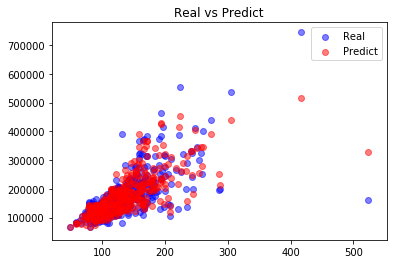

In [18]:
#Plot Real vs Predict
plt.scatter(X_val['GrLivArea'] * 0.092903, y_val,          color='blue', label='Real',    alpha=0.5)
plt.scatter(X_val['GrLivArea'] * 0.092903, y_pred_xgb,  color='red' , label='Predict', alpha=0.5)
plt.title("Real vs Predict")
plt.legend(loc='best')
plt.show()

# 8. Predic Test & Submission

In [19]:
X_test = test_005

# Use the model to make predictions
y_pred_test = xgb_model.predict(X_test)

submission = pd.DataFrame({'Id':test_id,'SalePrice':y_pred_test})

# Save results
submission.to_csv("submission.csv",index=False)